<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/ClasificadorBinario_inception_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

En este cuaderno probaremos la arquitectura efficientnet_b3 para ver si obtenemos unos mejores resultados.

## Efficientnet_b3

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 197 kB 35.1 MB/s 
     |████████████████████████████████| 60 kB 8.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 14.7 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
from fastai.vision.all import *

In [ ]:
!pip install wwf
!pip install nbdev

In [18]:
from wwf.utils import *
from wwf.vision.timm import *
import timm

In [20]:
timm.list_models('*inception*')[:10]

['adv_inception_v3',
 'ens_adv_inception_resnet_v2',
 'gluon_inception_v3',
 'inception_resnet_v2',
 'inception_v3',
 'inception_v4',
 'tf_inception_v3']

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [4]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-16 07:52:50 URL:https://uce7574707ed12c164ef6bc50d20.dl.dropboxusercontent.com/cd/0/inline2/BnReaXAloyTnXolMhcWTn8zg9qIABFnrSvmFxfHb6OrnR0s2TGLk306S1FFKAvxRjD2E-VK5cdVKHafGQpThzP4vHroIRlHu9fliS2ZHn66dozYo3k01u3alOUayVMNaoQKhiDnur0nsgpblMDMZ4eHNZM69bEDqJ7nwxyw9TiK1wm6Zkw7eq3xjXuYU7ksOQcP1mX7TMefqAuHRrnmU3XRc5tzUvgdouJkUvhzI96K3RfqTRhfnzhUgjHAa-eB-F2hCT4kcID1v8kuQBRh_wdc9Rs-30tSu7K4GGrAGuOroUJOOsfyCkb6FS-3ert3f1DyGQ8bX0TLujcShqXROo3Dxzgp0ALECWYfnlZZXr8qqD4NjzW4EoINMlBdZfklIM6qbGcc9fgXYPZevDesOONAELiY1-mD3HyQHB786jl5iNQ/file [138777773/138777773] -> "train.zip" [1]
2022-06-16 07:52:56 URL:https://uc657cd19b36610cd99fa03db651.dl.dropboxusercontent.com/cd/0/inline2/BnQvEc0PX6feZtKs43LC8oNwY90YZqo1dDlgcfswWc-7Z-QKINpCTSmn5mzaz37Kh7FUL0wXkbnYmR9Xd_zE5mlbJHgGLyLj2EC6F8Fwc9g8_z3BhE-P4qGbpXLfvUoGXGSxd3cHd779JaboMLEbhH24UMd8fXVPuy0yoDdT67iHm4zuxLdYDzEPIFYEVgP9UxgCwF1ePPCtKatQ4VqQL65C-0KIBJmrPfbb4vnUmRIYaUQ9mr4ftzav8c_vnv-c3or33zUk-WkX4sZ9-frA25exrmYijzpvVTcmcbEsJSUDMnDuYTr4Gvk291463TMmkyk

In [5]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [6]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [7]:
crearEstructura('dataset', ['normal', 'enfermedad'])

In [8]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [9]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

#### Mover imágenes:

In [10]:
import shutil

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(pathO + '/' + str(id) + '.png', pathD + '/normal')
    else:
        shutil.move(pathO + str(id) + '.png', pathD + '/enfermedad')

In [11]:
path = Path('dataset')

In [12]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [29]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [30]:
dls = db.dataloaders(path,bs=128)

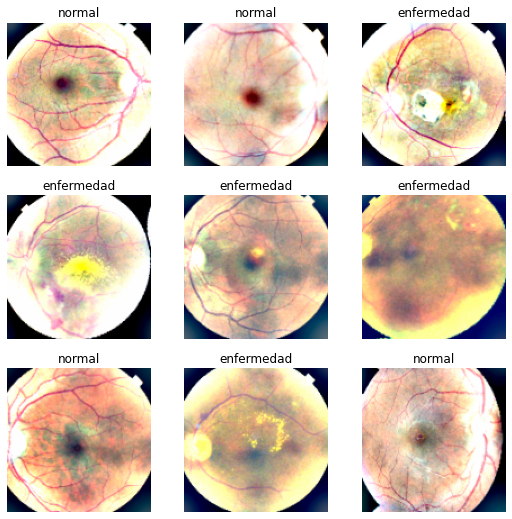

In [31]:
dls.show_batch()

In [32]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()
]

In [33]:
learn = timm_learner(dls, 'inception_v4', metrics=[error_rate, accuracy], cbs=callbacks)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth


SuggestedLRs(minimum=0.014454397559165954, steep=1.0964781722577754e-06, valley=0.0014454397605732083, slide=0.0063095735386013985)

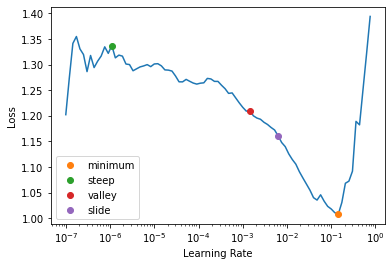

In [34]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.286422,0.884784,0.487500,0.512500,00:11


Better model found at epoch 0 with valid_loss value: 0.8847836256027222.


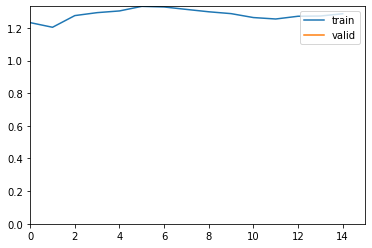

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.283075,0.896491,0.493750,0.506250,00:14
1,1.258131,0.884864,0.459375,0.540625,00:14
2,1.264633,0.899202,0.460938,0.539062,00:14
3,1.252016,0.914877,0.470313,0.529688,00:14
4,1.234197,0.926705,0.470313,0.529688,00:14
5,1.216059,0.912572,0.462500,0.537500,00:14
6,1.230698,0.893079,0.445312,0.554688,00:14
7,1.227509,0.846795,0.414062,0.585938,00:14
8,1.217088,0.835021,0.398438,0.601562,00:14
9,1.206787,0.843790,0.421875,0.578125,00:14


Better model found at epoch 0 with valid_loss value: 0.8964905738830566.


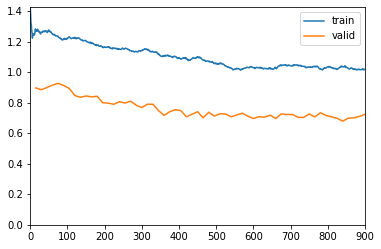

Better model found at epoch 1 with valid_loss value: 0.8848641514778137.
Better model found at epoch 7 with valid_loss value: 0.846794605255127.
Better model found at epoch 8 with valid_loss value: 0.8350211977958679.
Better model found at epoch 12 with valid_loss value: 0.7995045781135559.
Better model found at epoch 13 with valid_loss value: 0.7964234352111816.
Better model found at epoch 14 with valid_loss value: 0.7895857095718384.
Better model found at epoch 18 with valid_loss value: 0.7831891775131226.
Better model found at epoch 19 with valid_loss value: 0.7678302526473999.
Better model found at epoch 22 with valid_loss value: 0.7475801706314087.
Better model found at epoch 23 with valid_loss value: 0.7165626287460327.
Better model found at epoch 27 with valid_loss value: 0.7075809836387634.
Better model found at epoch 30 with valid_loss value: 0.7007105350494385.
Better model found at epoch 39 with valid_loss value: 0.6961178183555603.
Better model found at epoch 43 with valid_

In [35]:
learn.fine_tune(60,base_lr=1e-5)

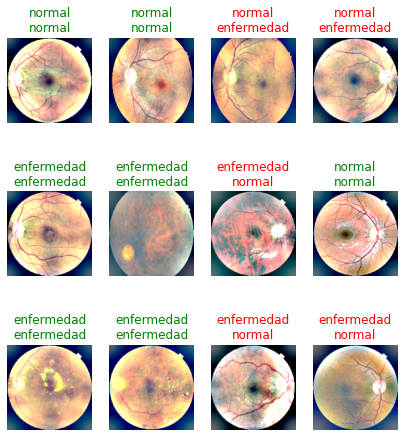

In [36]:
learn.show_results(max_n=12, figsize=(7,8))

## Evaluando el Modelo

In [37]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [38]:
learn.dls = dlsTest

Obtenemos una accuracy de 0.66.

In [39]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.3343749940395355.


(#3) [0.712525486946106,0.3343749940395355,0.6656249761581421]

Exportamos el modelo:

In [40]:
learn.to_fp32()
learn.export('modeloBinario_inception_v4.pkl')